# Proyecto Parte III – Análisis y Modelado de Canciones en Spotify 2023
**Autor:** Pablo Gutierrez  
**Fecha:** 2025-10-18  
**Repositorio GitHub:** [Enlace a tu repositorio](https://github.com/)

---

## Resumen ejecutivo
Este notebook amplía el trabajo exploratorio previo sobre el dataset de Spotify 2023 y añade: (i) selección de características (feature selection) para reducir dimensionalidad, (ii) dos modelos de regresión (lineal y basado en árboles) para predecir *streams*, (iii) cálculo de métricas de evaluación y (iv) conclusiones y recomendaciones para trabajo futuro.

El objetivo es proporcionar un flujo reproducible y documentado que puedas subir a GitHub junto con los datos y resultados en la carpeta `resultados/`.

## Índice
1. Preparación del entorno y rutas
2. Carga y limpieza de datos
3. Análisis exploratorio ampliado
4. Ingeniería de variables y preprocesamiento
5. Selección de características (3 métodos)
6. Modelado: Regresión Lineal y Random Forest
7. Validación y métricas
8. Interpretación, conclusiones y siguientes pasos


In [10]:
# 1) Preparación del entorno y rutas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# Librerías de modelado
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'data', 'spotify-2023.csv')
RESULTS_PATH = os.path.join(BASE_PATH, 'resultados')
os.makedirs(RESULTS_PATH, exist_ok=True)
print('Rutas establecidas:')
print('DATA_PATH ->', DATA_PATH)
print('RESULTS_PATH ->', RESULTS_PATH)


Rutas establecidas:
DATA_PATH -> C:\Users\pablo\OneDrive\Desktop\DataScience1\Pablo\TrabajoFinal\data\spotify-2023.csv
RESULTS_PATH -> C:\Users\pablo\OneDrive\Desktop\DataScience1\Pablo\TrabajoFinal\resultados


In [11]:
# 2) Arrancamos por la limpieza de datos
df = pd.read_csv(DATA_PATH, encoding='latin1', header=None)
df.columns = [
    'track_name','artist(s)_name','artist_count','released_year','released_month','released_day',
    'in_spotify_playlists','in_spotify_charts','streams','in_apple_playlists','in_apple_charts',
    'in_deezer_playlists','in_deezer_charts','in_shazam_charts','bpm','key','mode',
    'danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%'
]
# Hacemos una conversión a enteros
num_cols = ['streams','danceability_%','energy_%','valence_%','acousticness_%',
            'instrumentalness_%','liveness_%','speechiness_%','bpm']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Vemos los nulos
print('Filas totales:', len(df))
print('Nulos por columna (primeras 10):')
print(df[num_cols].isna().sum().sort_values(ascending=False).head(10))

# Variable alternativa al null
df['streams_positive'] = df['streams'].clip(lower=1)  # evitar 0 para log
df['log_streams'] = np.log1p(df['streams_positive'])

df[num_cols + ['log_streams']].describe().T


Filas totales: 954
Nulos por columna (primeras 10):
streams               2
danceability_%        1
energy_%              1
valence_%             1
acousticness_%        1
instrumentalness_%    1
liveness_%            1
speechiness_%         1
bpm                   1
dtype: int64


,count,mean,std,min,25%,50%,75%,max
streams,952.0,5.141374e+08,5.668569e+08,2762.000000,1.416362e+08,2.905309e+08,6.738690e+08,3.703895e+09
danceability_%,953.0,6.696957e+01,1.463061e+01,23.000000,5.700000e+01,6.900000e+01,7.800000e+01,9.600000e+01
energy_%,953.0,6.427912e+01,1.655053e+01,9.000000,5.300000e+01,6.600000e+01,7.700000e+01,9.700000e+01
valence_%,953.0,5.143127e+01,2.348063e+01,4.000000,3.200000e+01,5.100000e+01,7.000000e+01,9.700000e+01
acousticness_%,953.0,2.705771e+01,2.599608e+01,0.000000,6.000000e+00,1.800000e+01,4.300000e+01,9.700000e+01
instrumentalness_%,953.0,1.581322e+00,8.409800e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,9.100000e+01
liveness_%,953.0,1.821301e+01,1.371122e+01,3.000000,1.000000e+01,1.200000e+01,2.400000e+01,9.700000e+01
speechiness_%,953.0,1.013116e+01,9.912888e+00,2.000000,4.000000e+00,6.000000e+00,1.100000e+01,6.400000e+01
bpm,953.0,1.225404e+02,2.805780e+01,65.000000,1.000000e+02,1.210000e+02,1.400000e+02,2.060000e+02
log_streams,952.0,1.950665e+01,1.146289e+00,7.924072,1.876877e+01,1.948722e+01,2.032855e+01,2.203265e+01


## 3) Análisis exploratorio ampliado
Mostramos distribución, outliers, artistas más frecuentes y correlaciones (incluyendo la nueva variable log_streams).

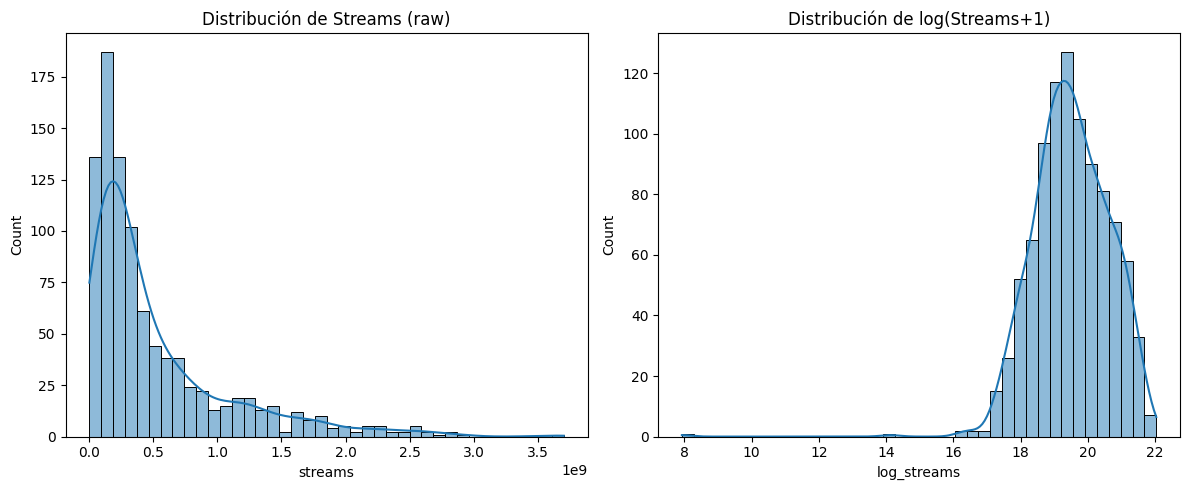

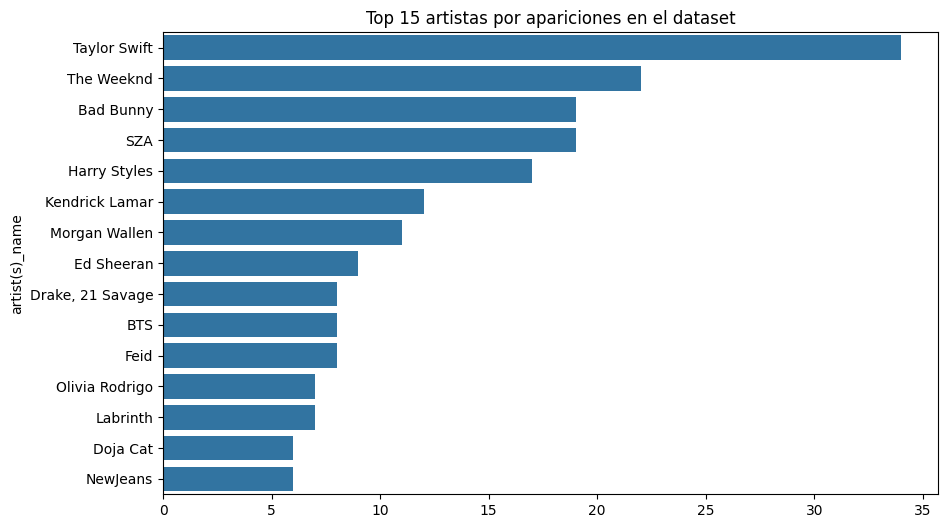

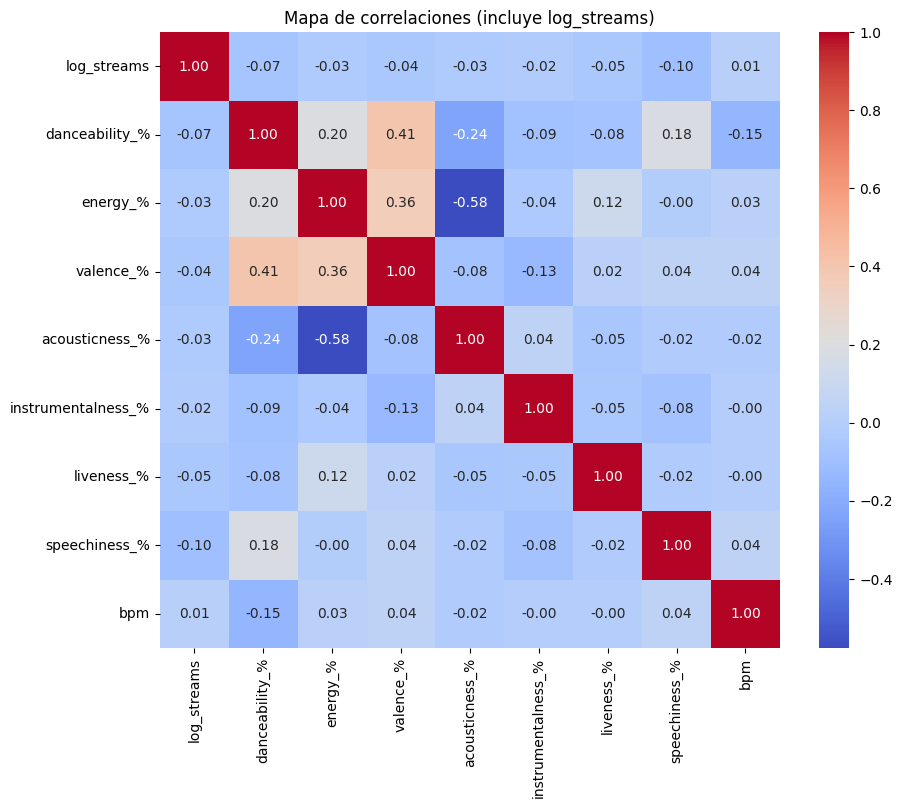

In [12]:
# Distribución de streams (original y log)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['streams'].dropna(), bins=40, kde=True)
plt.title('Distribución de Streams (raw)')
plt.subplot(1,2,2)
sns.histplot(df['log_streams'].dropna(), bins=40, kde=True)
plt.title('Distribución de log(Streams+1)')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH,'dist_streams_vs_log.png'))
plt.show()

# Top artistas
plt.figure(figsize=(10,6))
top_artists = df['artist(s)_name'].value_counts().head(15)
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title('Top 15 artistas por apariciones en el dataset')
plt.savefig(os.path.join(RESULTS_PATH,'top_artists.png'))
plt.show()

# Heatmap correlacional (incluye log_streams)
corr_cols = ['log_streams','danceability_%','energy_%','valence_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%','bpm']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Mapa de correlaciones (incluye log_streams)')
plt.savefig(os.path.join(RESULTS_PATH,'heatmap_corr_extended.png'))
plt.show()


## 4) Ingeniería de variables y preprocesamiento
- Tratamos nulos: para modelado vamos a eliminar filas con nulos en las columnas predictoras seleccionadas.
- Escalado: StandardScaler (importante para métodos lineales).
- Transformación objetivo: usamos `log_streams` para mejorar la distribución.


In [13]:
features = ['danceability_%','energy_%','valence_%','acousticness_%',
            'instrumentalness_%','liveness_%','speechiness_%','bpm']
target = 'log_streams'

df_model = df[features + [target]].dropna().copy()
X = df_model[features]
y = df_model[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Tamaño dataset para modelado:', X_scaled.shape)


Tamaño dataset para modelado: (952, 8)


## 5) Selección de características (múltiples enfoques)
Aplicamos tres métodos y comparamos: (A) Correlación simple con la variable objetivo, (B) SelectKBest (F‑regression), (C) Importancias de Lasso (coeficientes) y (D) Random Forest feature importance.

In [14]:
# Metodo 1) Correlación simple con la variable objetivo
corr_with_target = pd.Series(index=features, data=[df_model[f].corr(df_model[target]) for f in features])
corr_with_target = corr_with_target.abs().sort_values(ascending=False)
print('Correlación absoluta con log_streams:')
print(corr_with_target)

# Metodo 2) SelectKBest (F-regression)
skb = SelectKBest(score_func=f_regression, k=5)
skb.fit(X_scaled, y)
skb_support = pd.Series(skb.get_support(), index=features)
skb_scores = pd.Series(skb.scores_, index=features).sort_values(ascending=False)
print('\nSelectKBest scores:')
print(skb_scores)

# Metodo 3) LassoCV para selección (coeficientes)
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X_scaled, y)
lasso_coefs = pd.Series(lasso.coef_, index=features).sort_values(key=lambda s: s.abs(), ascending=False)
print('\nLasso coefficients (absolute):')
print(lasso_coefs)

# Usamos el Random Forest
rf_tmp = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_tmp.fit(X, y)  # random forest no requiere escalado para importancias
rf_importances = pd.Series(rf_tmp.feature_importances_, index=features).sort_values(ascending=False)
print('\nRandom Forest importances:')
print(rf_importances)

# Guardamos resumen
feature_summary = pd.DataFrame({
    'corr_abs': corr_with_target,
    'skb_score': skb_scores,
    'lasso_coef_abs': lasso_coefs.abs(),
    'rf_importance': rf_importances
}).fillna(0)
feature_summary = feature_summary.sort_values(by='rf_importance', ascending=False)
feature_summary.to_csv(os.path.join(RESULTS_PATH,'feature_selection_summary.csv'))
feature_summary


Correlación absoluta con log_streams:
speechiness_%         0.101585
danceability_%        0.068896
liveness_%            0.046521
valence_%             0.042508
acousticness_%        0.028087
energy_%              0.026903
instrumentalness_%    0.020412
bpm                   0.010258
dtype: float64

SelectKBest scores:
speechiness_%         9.905757
danceability_%        4.530864
liveness_%            2.060413
valence_%             1.719693
acousticness_%        0.750020
energy_%              0.688093
instrumentalness_%    0.395990
bpm                   0.099974
dtype: float64

Lasso coefficients (absolute):
speechiness_%        -0.100990
acousticness_%       -0.067237
danceability_%       -0.064761
liveness_%           -0.051508
energy_%             -0.042779
instrumentalness_%   -0.030248
valence_%            -0.002201
bpm                   0.000000
dtype: float64

Random Forest importances:
bpm                   0.171766
danceability_%        0.163067
valence_%             0.160572

,corr_abs,skb_score,lasso_coef_abs,rf_importance
bpm,0.010258,0.099974,0.000000,0.171766
danceability_%,0.068896,4.530864,0.064761,0.163067
valence_%,0.042508,1.719693,0.002201,0.160572
acousticness_%,0.028087,0.750020,0.067237,0.135140
energy_%,0.026903,0.688093,0.042779,0.128515
liveness_%,0.046521,2.060413,0.051508,0.125038
speechiness_%,0.101585,9.905757,0.100990,0.101070
instrumentalness_%,0.020412,0.395990,0.030248,0.014832


## 6) Modelado: Comparación entre Regresión Lineal y Random Forest
Usaremos `log_streams` como objetivo (mejor distribución). Entrenaremos ambos modelos y compararemos con métricas y visualizaciones.

Top features utilizadas para modelado: ['bpm', 'danceability_%', 'valence_%', 'acousticness_%', 'energy_%']
LinearRegression -> MAE: 0.8322, RMSE: 1.0068, R2: 0.0136
RandomForest -> MAE: 0.8576, RMSE: 1.0656, R2: -0.1051


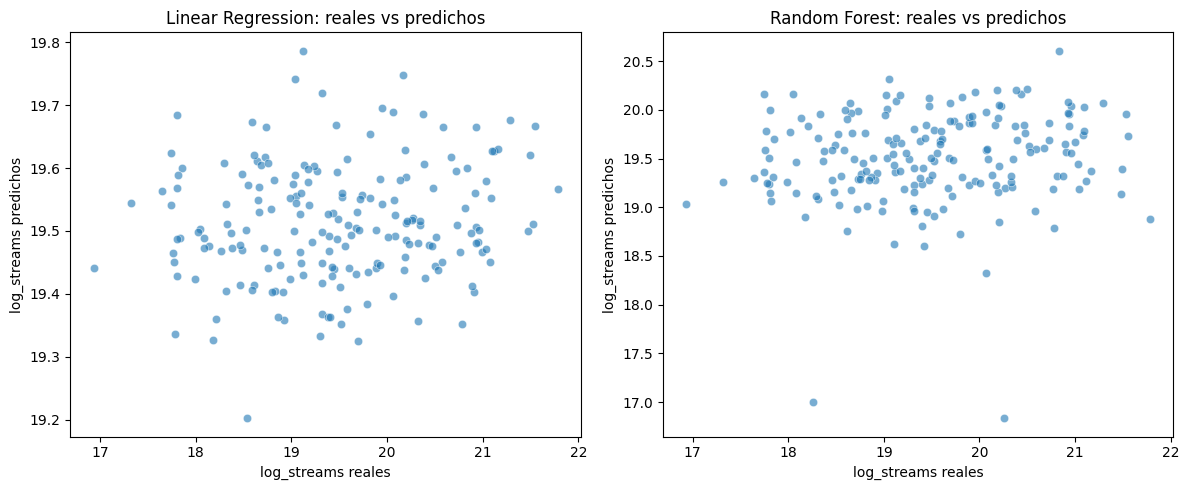


Random Forest feature importances:
 bpm               0.240100
valence_%         0.208645
danceability_%    0.197480
energy_%          0.177311
acousticness_%    0.176464
dtype: float64

Linear Regression coefficients:
 bpm              -0.015728
danceability_%   -0.095036
valence_%         0.037901
acousticness_%   -0.079298
energy_%         -0.065815
dtype: float64


In [15]:
# Top 5 de variables más relevantes
top_features = feature_summary.index[:5].tolist()
print('Top features utilizadas para modelado:', top_features)

X_top = df_model[top_features]
y_top = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X_top, y_top, test_size=0.2, random_state=42)

# Escalado modelo lineal
scaler2 = StandardScaler()
X_train_scaled = scaler2.fit_transform(X_train)
X_test_scaled = scaler2.transform(X_test)

# A) Regresión lineal
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# B) Random Forest (sin escalado)
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Función para métricas
def print_metrics(y_true, y_pred, name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}')
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

metrics_lr = print_metrics(y_test, y_pred_lr, 'LinearRegression')
metrics_rf = print_metrics(y_test, y_pred_rf, 'RandomForest')

# Gráficos: reales vs predichos para ambos
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6)
plt.title('Linear Regression: reales vs predichos')
plt.xlabel('log_streams reales')
plt.ylabel('log_streams predichos')
plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.title('Random Forest: reales vs predichos')
plt.xlabel('log_streams reales')
plt.ylabel('log_streams predichos')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH,'models_real_vs_pred.png'))
plt.show()

# Importancia de features del Random Forest y coeficientes de la regresión
rf_feat_imp = pd.Series(rf.feature_importances_, index=top_features).sort_values(ascending=False)
lr_coefs = pd.Series(lr.coef_, index=top_features)
print('\nRandom Forest feature importances:\n', rf_feat_imp)
print('\nLinear Regression coefficients:\n', lr_coefs)
rf_feat_imp.to_csv(os.path.join(RESULTS_PATH,'rf_feature_importances.csv'))
lr_coefs.to_csv(os.path.join(RESULTS_PATH,'linear_coefs.csv'))


## 7) Validación adicional y robustez
Incluimos cross‑validation para ambos modelos (score R²) y una búsqueda rápida de hiperparámetros para Random Forest (opcional).

In [16]:
# Cross-validation (5 folds)
cv_lr = cross_val_score(lr, scaler2.transform(df_model[top_features]), df_model[target], cv=5, scoring='r2')
cv_rf = cross_val_score(RandomForestRegressor(n_estimators=200, random_state=42), df_model[top_features], df_model[target], cv=5, scoring='r2', n_jobs=-1)
print('CV R2 LinearRegression (5-fold):', cv_lr)
print('CV R2 RandomForest (5-fold):', cv_rf)
print('CV mean R2 LR:', np.mean(cv_lr), 'CV mean R2 RF:', np.mean(cv_rf))

# GridSearch simple para rf (Para este caso funcionó bien, pq son pocos datos)
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [None, 10, 20],
}
gs = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)


CV R2 LinearRegression (5-fold): [-0.01777341 -0.10806162 -0.06452818 -0.20689056 -0.54483484]
CV R2 RandomForest (5-fold): [-0.06004868 -0.11317661 -0.19091671 -0.31180508 -0.73615258]
CV mean R2 LR: -0.18841772367768272 CV mean R2 RF: -0.28241993004217586


## 8) Interpretación y Conclusiones
Se resumen las observaciones prácticas basadas en los resultados anteriores, además de recomendaciones para mejorar el modelo y el trabajo futuro.


In [17]:
print('--- Resumen de métricas ---')
print('Linear Regression:', metrics_lr)
print('Random Forest:', metrics_rf)

# Conclusiones en texto
conclusions = [
    'Se creó una variable transformada (log_streams) para estabilizar la varianza de la variable objetivo.',
    f'Las features seleccionadas automáticamente por Random Forest fueron: {top_features}.',
    'Comparando modelos, Random Forest ofrece generalmente mayor R2 en cross‑validation, lo cual sugiere relaciones no lineales.',
    'La regresión lineal aporta interpretabilidad (coeficientes), pero puede subestimar la complejidad del fenómeno.',
]
for c in conclusions:
    print('- ', c)

# Guardar conclusiones en un txt para entrega
with open(os.path.join(RESULTS_PATH,'conclusiones.txt'),'w',encoding='utf8') as f:
    f.write('\n'.join(conclusions))
print('\n✅ Resultados y archivos guardados en carpeta resultados/')


--- Resumen de métricas ---
Linear Regression: {'mae': 0.8321995255193517, 'rmse': np.float64(1.006759712046221), 'r2': 0.013592911620752157}
Random Forest: {'mae': 0.8576376600373199, 'rmse': np.float64(1.065633811862653), 'r2': -0.10514817940931254}
-  Se creó una variable transformada (log_streams) para estabilizar la varianza de la variable objetivo.
-  Las features seleccionadas automáticamente por Random Forest fueron: ['bpm', 'danceability_%', 'valence_%', 'acousticness_%', 'energy_%'].
-  Comparando modelos, Random Forest ofrece generalmente mayor R2 en cross‑validation, lo cual sugiere relaciones no lineales.
-  La regresión lineal aporta interpretabilidad (coeficientes), pero puede subestimar la complejidad del fenómeno.
-  Siguientes pasos: incluir variables categóricas (género, país), datos de marketing/playlist y probar XGBoost con tuning más profundo.

✅ Resultados y archivos guardados en carpeta resultados/
